## Needed Libraries
 - **Pandas** is used to load files and to analyze certain data
 - **Numpy** is used to perform some mathematical calculations and to use arrays
 - **Matplotlib** is used to plot the data

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import json

### Histograms for monthly values
First we'll use monthly values to plot a histogram of all the data and seasonal ones, we'll load the values located in the file *itcwv_monthly.txt*

The ***loadlist()*** function is used to load a text file as a list

In [5]:
def loadlist(array, name='file'):
    name = name + '.txt'
    with open(name, "r") as f:
        for line in f:
            array.append(float(line.strip()))

In [271]:
tcwv_m = []
loadlist(tcwv_m, 'TCWV/ElAlto/itcwv_monthly')

The ***plothist()*** function is used to plot a histogram from a list, the parameters are:
 - The list
 - The density ***p*** for percentages and ***f*** for frequencies
 - The title of the plot (Optional)
 - The X label of the plot (Optional)
 - The Y label of the plot (Optional)
 - The minimum and maximum values of X axis (Optional)
 - The minimum and maximum values of Y axis (Optional)
 - The number of bins desired (default is 10)

In [91]:
def plothist(array, den='p', title=0, xl=0, yl=0, xmin=0, xmax=0, ymin=0, ymax=0, nb=10):
    den = True if den == 'p' else None
    hist, bin_edges = np.histogram(array, bins = nb, density=den)
    r_bin_edges = np.round(bin_edges,0)
    hist = hist*100 if den else hist
    plt.bar(r_bin_edges[:-1], hist, width = 0.8, color='#0504aa',alpha=0.8)
    plt.ylim(ymin, ymax) if ymax != 0 else None
    plt.xlim(xmin, xmax) if xmax != 0 else None
    plt.grid(axis='y', alpha=0.75)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title,fontsize=15) if title != 0 else None
    plt.xlabel(xl, fontsize=15) if xl != 0 else None
    plt.ylabel(yl, fontsize=15) if yl != 0 else None
    plt.show()
    return hist, bin_edges, r_bin_edges

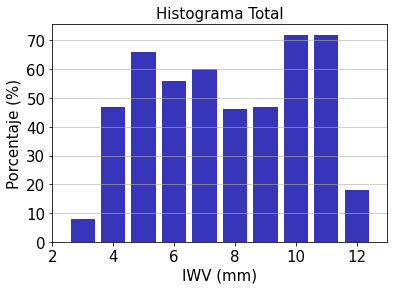

In [95]:
th, te, tre = plothist(tcwv_m, 'f', 'Histograma Total', 'IWV (mm)', 'Porcentaje (%)', 2, 13)

### Seasonal Histograms
To plot seasonal histograms we'll create a list for each season and we'll use the function ***ex_season()*** to extract values from one month to another

In [101]:
def ex_season(array, start, end):
    pos = 0
    c = 0
    y = int((len(array)/12))
    aux = [0] * (end - start + 1) * y
    for i in range(0,y):
        for j in range(start,end + 1):
            aux[c] = array[pos + j]
            c += 1
        pos += 12
    return aux

In [42]:
summertcwv = ex_season(tcwv_m, 0, 2)
autumntcwv = ex_season(tcwv_m, 3, 5)
wintertcwv = ex_season(tcwv_m, 6, 8)
springtcwv = ex_season(tcwv_m, 9, 11)

### Summer Histogram

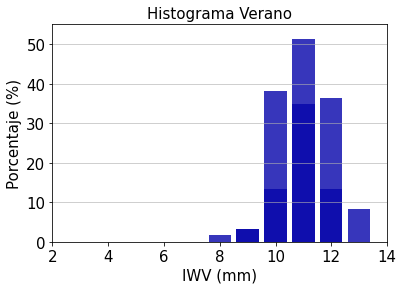

In [97]:
su_h, su_e, su_re = plothist(summertcwv, 'p', 'Histograma Verano', 'IWV (mm)', 'Porcentaje (%)', 2 , 14, 0, 55)

### Autumn Histogram

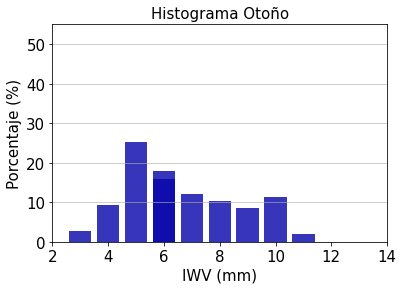

In [98]:
au_h, au_e, au_re = plothist(autumntcwv, 'p', 'Histograma Otoño', 'IWV (mm)', 'Porcentaje (%)', 2 , 14, 0, 55)

### Winter Histogram

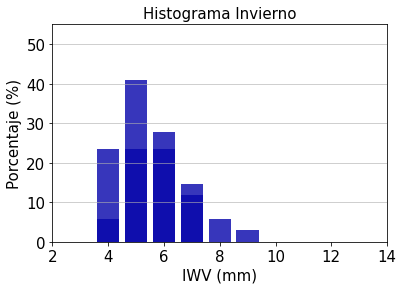

In [99]:
wi_h, wi_e, wi_re = plothist(wintertcwv, 'p', 'Histograma Invierno', 'IWV (mm)', 'Porcentaje (%)', 2 , 14, 0, 55)

### Spring Histogram

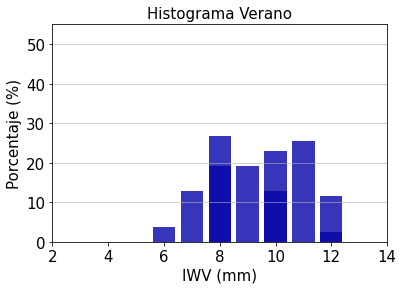

In [100]:
sp_h, sp_e, sp_re = plothist(springtcwv, 'p', 'Histograma Verano', 'IWV (mm)', 'Porcentaje (%)', 2 , 14, 0, 55)

### CCDF Plot

In [241]:
def plotcdf(array, plot=1):
    ccdf, X, _ = plt.hist(array, bins = 50, density=True, log=True, cumulative=-1, histtype='step')
    X = X[:-1]
    ccdf = ccdf * 100
    plt.clf()
    plt.grid(True, which="both")
    plt.semilogy(X, ccdf, label='CCDF')
    plt.legend(loc='best')
    plt.xlabel('IWV (mm)')
    plt.ylabel('Probabilidad (%)')
    plt.title('CCDF')
    plt.show() if plot == 1 else plt.clf()
    return X, ccdf

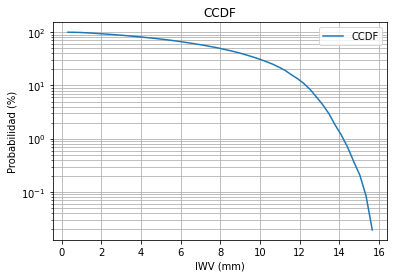

In [255]:
X, ccdf = plotcdf(tcwv_m)

### Water Vapor Attenuation

In [311]:
wat_file = pd.read_csv('ITUFiles/wat676.csv')
oxy_file = pd.read_csv('ITUFiles/oxy676.csv')
fw = wat_file['fw'].to_numpy()
b1 = wat_file['b1'].to_numpy()
b2 = wat_file['b2'].to_numpy()
b3 = wat_file['b3'].to_numpy()
b4 = wat_file['b4'].to_numpy()
b5 = wat_file['b5'].to_numpy()
b6 = wat_file['b6'].to_numpy()
fo = oxy_file['fo'].to_numpy()
a1 = oxy_file['a1'].to_numpy()
a2 = oxy_file['a2'].to_numpy()
a3 = oxy_file['a3'].to_numpy()
a4 = oxy_file['a4'].to_numpy()
a5 = oxy_file['a5'].to_numpy()
a6 = oxy_file['a6'].to_numpy()

In [312]:
def itu676(f, p, rho, T):
    # p: dry air presure (hPa)
    # e: water vaour partial pressure (hPa)
    # theta (Θ): 300/T
    # T: Temperature
    theta = 300/T
    e = (rho*T)/216.7
    So = a1 * (1e-7) * p * (theta**3) * np.exp(a2 * (1 - theta))
    Sw = b1 * (1e-1) * e * (theta**3.5) * np.exp(b2 * (1 - theta))
    deltao = (a5 + a6 * theta) * (1e-4) * (p + e) * (theta**0.8)
    deltaw = 0
    deltafo_wd = a3 * (1e-4) * (p * (theta**(0.8 - a4)) + 1.1 * e * theta)
    deltafw_wd = b3 * (1e-4) * (p * (theta**b4) + b5 * e * (theta**b6))
    deltafo = np.sqrt(deltafo_wd**2 + 2.25e-6)
    deltafw = 0.535 * deltafw_wd + np.sqrt((0.217 * deltafw_wd**2) + (2.1316e-12 * (fw**2))/(theta))
    Fo = ((f)/(fo)) * (((deltafo - deltao * (fo - f))/(deltafo**2 + (fo - f)**2))+((deltafo - deltao * (fo + f))/(deltafo**2 + (fo + f)**2)))
    Fw = ((f)/(fw)) * (((deltafw - deltaw * (fw - f))/(deltafw**2 + (fw - f)**2))+((deltafw - deltaw * (fw + f))/(deltafw**2 + (fw + f)**2)))
    d = (5.6e-4) * (p + e) * (theta**0.8)
    N2Df = f * p * theta**2 * (((6.14e-5)/(d * (1+(f/d)**2)))+((1.4e-12 * p * theta**1.5)/(1 + 1.9e-5 * f**1.5)))
    N2f = sum(Fo * So) + sum(Fw * Sw) + N2Df
    y = 0.182 * f * N2f
    ywv = 0.182 * f * sum(Fw * Sw)
    yox = 0.182 * f * (sum(Fo * So) + N2Df)
    return y, ywv, yox

In [226]:
def get_elevation(lat, lon):
    key = 'Ai9NLeGblweg0P_Br_bKnbLVkkRgbG6RlH4k5FrbBctSqD32KHMuFQmRyX-apadI'
    url = 'https://dev.virtualearth.net/REST/v1/Elevation/List?key=' + key + '&points=' + str(lat) + ',' + str(lon)
    response = urllib.request.urlopen(url)
    data = json.loads(response.read().decode())
    elevation = data['resourceSets'][0]['resources'][0]['elevations'][0]
    return elevation, elevation / 1000

In [262]:
def calc_at(daily_tcwv, freq, lat, lon):
    freq = [freq] if type(freq)!=list else freq
    daily_at = [np.empty(0)] * len(freq)
    f_ref = 20.6
    p_ref = 845
    hs = get_elevation(lat,lon)[1]
    c = 0
    for f in freq:
        a = 0.2048 * np.exp(-((f-22.43)/(3.097))**2) + 0.2326 * np.exp(-((f-183.5)/(4.096))**2) + 0.2073 * np.exp(-((f-325)/(3.651))**2) - 0.1113
        b = 8.741e4 * np.exp(-0.587 * f) + 312.2 * f ** -2.38 + 0.723
        if hs < 0:
            h = 0
        elif hs >= 0 and hs < 4:
            h = hs
        else:
            h = 4
        # print(a)
        # print(b)
        for iwv in daily_tcwv:
            rho_vref = iwv / 2.38
            t_ref = 14 * np.log(0.22*iwv/2.38) + 3 + 273.15
            if f <= 20:
                a_w = (0.0176 * iwv * itu676(f, p_ref, rho_vref, t_ref)[1])/(itu676(f_ref, p_ref, rho_vref, t_ref)[1])
            else:
                a_w = (a * (h ** b) + 1)*(0.0176 * iwv * itu676(f, p_ref, rho_vref, t_ref)[1])/(itu676(f_ref, p_ref, rho_vref, t_ref)[1])
            daily_at[c] = np.append(daily_at[c], a_w)
        c += 1
    return daily_at

### El Alto

Data loading from a text file

In [273]:
tcwv_d = []
loadlist(tcwv_d, 'TCWV/ElAlto/itcwv_12')

Integrated Water Vapor Attenuation

In [276]:
at_20, at_40, at_50, at_75 = calc_at(tcwv_d, [20, 40, 50, 75], -16.51, -68.17)

CCDF of the IWV Attenuation

In [304]:
X_20, ccdf_20 = plotcdf(at_20, 0)
X_40, ccdf_40 = plotcdf(at_40, 0)
X_50, ccdf_50 = plotcdf(at_50, 0)
X_75, ccdf_75 = plotcdf(at_75, 0)

<Figure size 432x288 with 0 Axes>

Plot of the attenuation

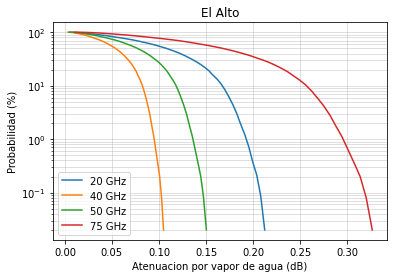

In [309]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(X_20, ccdf_20, label='20 GHz')
plt.semilogy(X_40, ccdf_40, label='40 GHz')
plt.semilogy(X_50, ccdf_50, label='50 GHz')
plt.semilogy(X_75, ccdf_75, label='75 GHz')
plt.legend(loc='best')
plt.title('El Alto')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

### La Guardia

In [314]:
tcwv_d = []
loadlist(tcwv_d, 'TCWV/LaGuardia/itcwv_12')
at_20, at_40, at_50, at_75 = calc_at(tcwv_d, [20, 40, 50, 75], -17.9074, -63.3266)
X_20, ccdf_20 = plotcdf(at_20, 0)
X_40, ccdf_40 = plotcdf(at_40, 0)
X_50, ccdf_50 = plotcdf(at_50, 0)
X_75, ccdf_75 = plotcdf(at_75, 0)

<Figure size 432x288 with 0 Axes>

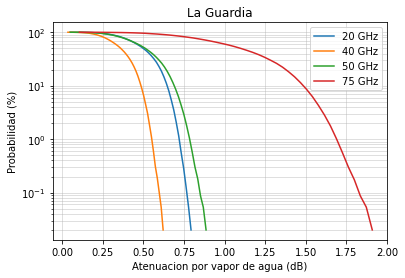

In [315]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(X_20, ccdf_20, label='20 GHz')
plt.semilogy(X_40, ccdf_40, label='40 GHz')
plt.semilogy(X_50, ccdf_50, label='50 GHz')
plt.semilogy(X_75, ccdf_75, label='75 GHz')
plt.legend(loc='best')
plt.title('La Guardia')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

### San Ignacio de Moxos

In [321]:
tcwv_d = []
loadlist(tcwv_d, 'TCWV/SIMoxos/itcwv_12')
at_20, at_40, at_50, at_75 = calc_at(tcwv_d, [20, 40, 50, 75], -14.996641, -65.640895)
X_20, ccdf_20 = plotcdf(at_20, 0)
X_40, ccdf_40 = plotcdf(at_40, 0)
X_50, ccdf_50 = plotcdf(at_50, 0)
X_75, ccdf_75 = plotcdf(at_75, 0)

<Figure size 432x288 with 0 Axes>

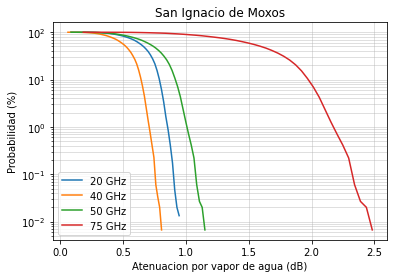

In [322]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(X_20, ccdf_20, label='20 GHz')
plt.semilogy(X_40, ccdf_40, label='40 GHz')
plt.semilogy(X_50, ccdf_50, label='50 GHz')
plt.semilogy(X_75, ccdf_75, label='75 GHz')
plt.legend(loc='best')
plt.title('San Ignacio de Moxos')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

### UPB

In [318]:
tcwv_d = []
loadlist(tcwv_d, 'TCWV/UPB/itcwv_12')
at_20, at_40, at_50, at_75 = calc_at(tcwv_d, [20, 40, 50, 75], -17.399253, -66.218466)
X_20, ccdf_20 = plotcdf(at_20, 0)
X_40, ccdf_40 = plotcdf(at_40, 0)
X_50, ccdf_50 = plotcdf(at_50, 0)
X_75, ccdf_75 = plotcdf(at_75, 0)

<Figure size 432x288 with 0 Axes>

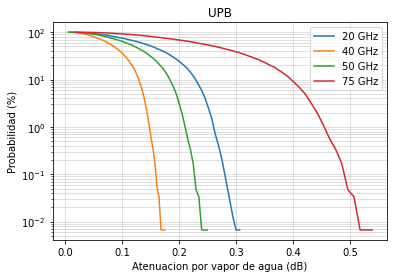

In [320]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(X_20, ccdf_20, label='20 GHz')
plt.semilogy(X_40, ccdf_40, label='40 GHz')
plt.semilogy(X_50, ccdf_50, label='50 GHz')
plt.semilogy(X_75, ccdf_75, label='75 GHz')
plt.legend(loc='best')
plt.title('UPB')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()